In [2]:
##Load all the required libraries...

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
import time
import pandas as pd

from tools.base import *
from tools.ddmtd import ddmtd
from time import sleep

In [3]:
server="pi@192.168.222.5" # your ip address might be different

## IMPORTANT##
## make sure you have your ssh keys set-up properly
## END IMPORTANT##
## Contact rohith.saradhy@cern.ch for password to the RPi

In [4]:
#Copy Flash_Firmware scripts to the Raspberry Pi.
!rsync -ra ../rpi_side/Flash_Firmware {server}:

In [69]:
## Flash The Firmware to the Nexys Board flash memory
## Physically restart the Nexys Board after the flash. Or click the "PROG" button on Nexys Video Board.

!../rpi_side/Flash_Nex.sh ../rpi_side/HEX_Files/2022_12_03_v2_032.hex {server}   # clocked at neg edge

#If "chip ID incorrect" error occurs, repeat the process

# Successfull Flashing would look similar to the following:
# We are in dir::/home/pi/Flash_Firmware

# 	FLASH MEMORY WRITE

# Current Chip ID: 010219

# Reading hex file:	 Success
# Number of Bytes: 	 2161808
# Erasing sectors: 	 Success 
# Flashing memory: 	 Success 


# The flash memory was successfully written.

2022_12_03_v2_032.hex                         100% 3312KB  18.3MB/s   00:00    
We are in dir::/home/pi/Flash_Firmware

	FLASH MEMORY WRITE

Current Chip ID: 010219

Reading hex file:	 Success
Number of Bytes: 	 1695588
Erasing sectors: 	 Success 
Flashing memory: 	 Success 

The flash memory was successfully written.


In [70]:
# restart FPGA & check firmware
sleep(1)
!../rpi_side/runAtNex.sh ../restart_FPGA.sh 0 0 {server}
sleep(1)
#Check Version Number
!rsync -ra ../rpi_side/Flash_Firmware {server}:
!../rpi_side/runAtNex.sh bin/check_firmware.exe 0 1 {server} #flash the configuration file
# Should return: 
# FirmwareVersion::2.030 at least

Scipt Location::/home/rsaradhy/work/nexys_ddmtd_github/rpi_side
Scipt Location::/home/rsaradhy/work/nexys_ddmtd_github/rpi_side
RESET DONE 
HEATING 1 STATUS: 0
HEATING 2 STATUS: 0
Firmware Version: 2.032 


In [71]:
# Setting all the variables...
N=100000  #Setting the DDMTD N
freq="40.079"#in MHz #Setting the input clock frequency
pll_config_folder="../rpi_side/PLL_Conf/bcp_configs/"
fig_save_folder = f"./bcp_test/figures/N{N}/"
data_save_folder = f"./bcp_test/data/N{N}/"
!mkdir -p {fig_save_folder} #create those directories
!mkdir -p {data_save_folder} #create those directories
run_number = 1
run_name   = f"bcp_testRun{run_number}"

## PLL Configs

In [72]:
## Availble Configurations...
!ls -t {pll_config_folder}

bcp_nexys_1000001_40.079MHz.h  bcp_nexys_100001_40.079MHz.h
bcp_nexys_10001_40.079MHz.h    bcp_nexys_conf.h


In [73]:
## Configuring the PLL. This needs to be done everytime the board is restarted/ loses power.
##Selecting the Register File##

pll_config = f"{pll_config_folder}bcp_nexys_{N+1}_{freq}MHz.h" #Selecting the configuration according to N, freq
print("Using PLL Config: \n ",pll_config)
print("\n\n")
!scp {pll_config} {server}:Flash_Firmware/include/Si5344_REG.h #Copy the config to the RPi as Si5344
## Compile and Running configuration script
!../rpi_side/runAtNex.sh bin/ddmtd_pll.exe 1 1 {server} #flash the configuration file
#The output should look like the following::
# Done Compiling MEM
# Done Compiling PLL
# address = 0x0514, value = 0x01 ; Value returned = 0x00   
# address = 0x001c, value = 0x01 ; Value returned = 0x00 

# After configuration, D304 will blink every 500 cycles of the beat clock

Using PLL Config: 
  ../rpi_side/PLL_Conf/bcp_configs/bcp_nexys_100001_40.079MHz.h



bcp_nexys_100001_40.079MHz.h                  100%   45KB  11.0MB/s   00:00    
Scipt Location::/home/rsaradhy/work/nexys_ddmtd_github/rpi_side
Done Compiling data_acq
Done Compiling PLL
Done Compiling CheckFirmware
address = 0x0514, value = 0x01 ; Value returned = 0xff   
address = 0x001c, value = 0x01 ; Value returned = 0xff   


## Data Acquisition

In [74]:
!../rpi_side/runAtNex.sh bin/data_acq.exe 1 1 {server}
# Copy over the files...
!scp {server}:Flash_Firmware/data/ddmtd1.txt {data_save_folder+run_name}_ddmtd1.txt
!scp {server}:Flash_Firmware/data/ddmtd2.txt {data_save_folder+run_name}_ddmtd2.txt 

Scipt Location::/home/rsaradhy/work/nexys_ddmtd_github/rpi_side
Done Compiling data_acq
Done Compiling PLL
Done Compiling CheckFirmware
HEATING 1 STATUS: 0
HEATING 2 STATUS: 0
Data_Allocated: 2*0.200002 MB 
RESET DONE 
Counts Recorded for DDMTD1: 24999 
Counts Recorded for DDMTD2: 24999 
Efficiency for DDMTD1: 12.499500 % 
Efficiency for DDMTD2: 12.499500 % 
ddmtd1.txt                                    100%  320KB  20.6MB/s   00:00    
ddmtd2.txt                                    100%  320KB  11.2MB/s   00:00    


In [75]:
df1 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
df2 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
df = pd.concat((df1,df2),axis=1)

In [80]:
df

,edge1,ddmtd1,edge2,ddmtd2
0,0,19181,0,19471
1,1,69312,1,69491
2,0,119187,0,119480
3,1,169307,1,169490
4,0,219182,0,219475
...,...,...,...,...
24994,0,1248719186,0,1248919475
24995,1,1248769307,1,1248969492
24996,0,1248819181,0,1249019479
24997,1,1248869305,1,1249069494


In [76]:
# Create a DDMTD Object for analysis of the data
data = ddmtd(df,channel=(1,2)) #creates a ddmtd object
#Setting the correct N can recalculating all the scalings
data.N = N  
# data.N = 1000000 
data.INPUT_FREQ = 40.079*10**6 #In Hz 
data.Recalc()

Recalculations Done.
N = 100000
Input Freq = 40.079 MHz
PLL Freq = 40.07859921400786 MHz
BEAT Freq = 0.4007859921400786 kHz
Err = 0.24950722323411262 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 0.40077979679718134 kHz
BEAT Freq DDMTD2 = 0.4007797387117337 kHz
Recovered N of DDMTD1 = 100001.54582215639
Recovered N of DDMTD2 = 100001.56031549025


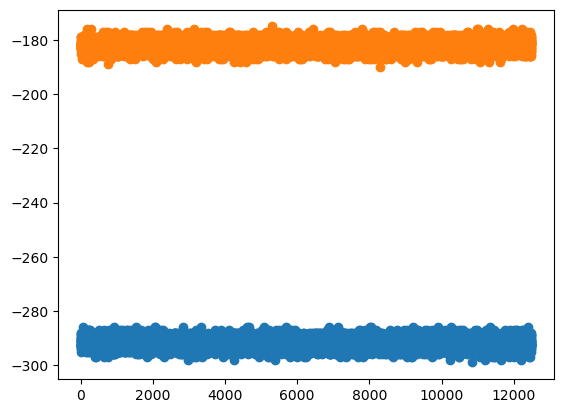

In [77]:
plt.scatter(range(data.TIE_fall.size),data.TIE_fall)
plt.scatter(range(data.TIE_rise.size),data.TIE_rise)

In [78]:
print(
np.mean(data.TIE_fall)*data.MULT_FACT*1000,
np.mean(data.TIE_rise)*data.MULT_FACT*1000
)

-72.77045595998513 -45.421613181998865


True
True


(array([ 2.79296208e+03, -4.52916505e-02, -4.42051026e-04]),
 array([3.04004916e+01, 5.55553610e-06, 5.55753051e-06]))

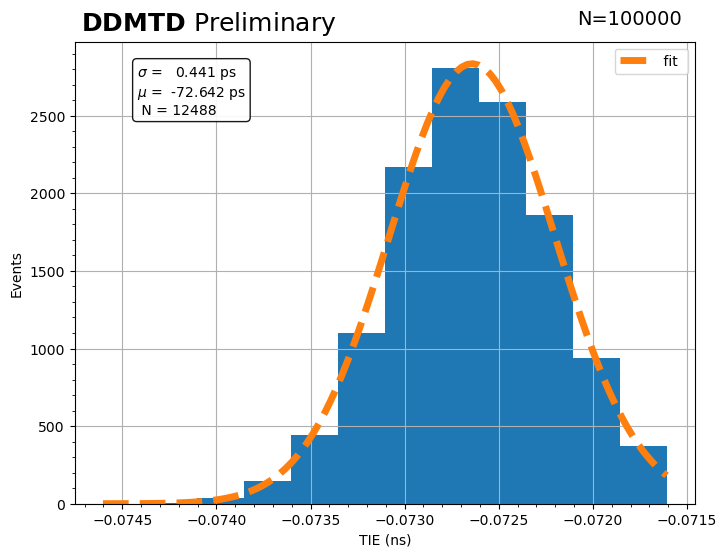

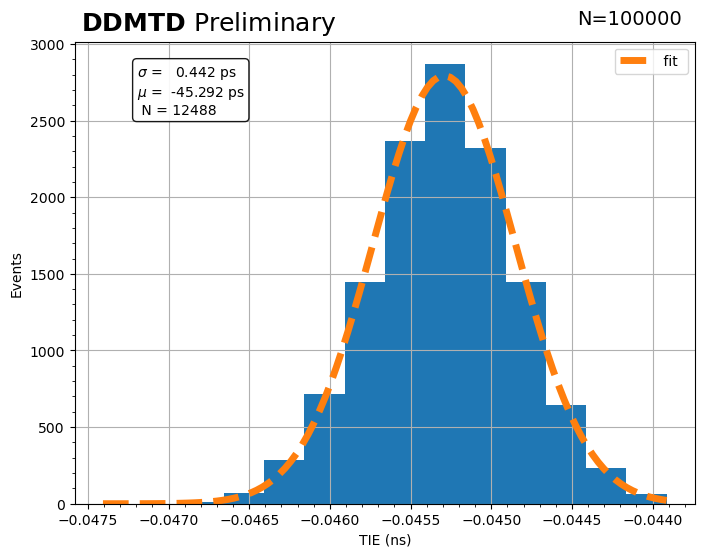

In [79]:
data.drawTIE(sep='TIE_FALL',fit=True,draw=True)
data.drawTIE(sep='TIE_RISE',fit=True,draw=True)